In [5]:
import os
import numpy as np
import pandas as pd
from numpy.random import shuffle
from sklearn.decomposition import IncrementalPCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression

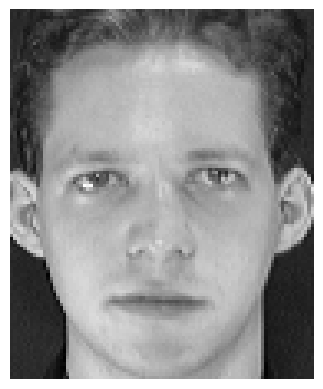

In [6]:
import cv2
import matplotlib.pyplot as plt

def read_pgm(file_path):
    return cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

def show_image(image_data):
    plt.imshow(image_data, cmap='gray')
    plt.axis('off')  # Hide axis labels
    plt.show()

file_path = f'../ATT images/s1/1.pgm'
image_data = read_pgm(file_path)
show_image(image_data)

In [7]:
image_data.shape

(112, 92)

In [8]:
def get_data(path_data='../ATT images', test_size=0.2, is_shuffle=True):
    folders = [f's{i+1}' for i in range(40)]
    X, y = [], []

    for i in range(1, 41):
        path = path_data + f'/s{i}'
        files = os.listdir(path)
        num_files = len(files)

        if is_shuffle:
            files = shuffle(files)

        for file in os.listdir(path):
            path = path_data + f'/s{i}/' + file
            image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            pixels = np.reshape(image, [1, image.shape[0] * image.shape[1]])
            pixels = np.asarray(pixels)

            if len(X) == 0:
                X = pixels
            else:
                X = np.vstack([X, pixels])
            y.append(f's{i}')

    return X, np.asarray(y)

In [9]:
X, y = get_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43)

In [10]:
n_components_pca = 50
pca = IncrementalPCA(n_components=n_components_pca)
X_train_reduced = pca.fit_transform(X_train)
X_test_reduced = pca.transform(X_test)

In [11]:
predictions = {}

# Euclidean

In [12]:
y_pred = []
for i in range(80):
    min_ = np.argmin(np.sqrt(np.sum((X_train_reduced - X_test_reduced[i])**2,axis=1)))
    y_pred.append(y_train[min_])

In [13]:
predictions['euclidean'] = y_pred

In [14]:
from sklearn.model_selection import KFold
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

****

**Chọn trường hợp accuracy của logistic model khác 1**

In [15]:
lr = LogisticRegression()
lr.fit(X_train_reduced, y_train)
y_pred = lr.predict(X_test_reduced)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# One-hot encoding for probability calculation (adapt if necessary)
y_test_onehot = pd.get_dummies(y_test, prefix='label_')  # Assuming 'label_' prefix for clarity
y_pred_onehot = pd.get_dummies(y_pred, prefix='label_')

# ROC AUC score with multiclass handling
roc_auc_macro = roc_auc_score(y_test_onehot, y_pred_onehot, average='macro', multi_class='ovo')  

print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
print('roc_auc: ', roc_auc_macro)

accuracy: 0.975
recall: 0.980952380952381
precision: 0.9885714285714287
f1-score: 0.9785714285714285
roc_auc:  0.9901051329622758


# Random Forest

In [16]:
prediction_results = {}

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

**Normal**

In [18]:
rfr = RandomForestClassifier()
rfr.fit(X_train_reduced,y_train)
y_pred = rfr.predict(X_test_reduced)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# One-hot encoding for probability calculation (adapt if necessary)
y_test_onehot = pd.get_dummies(y_test, prefix='label_')  # Assuming 'label_' prefix for clarity
y_pred_onehot = pd.get_dummies(y_pred, prefix='label_')

# ROC AUC score with multiclass handling
roc_auc_macro = roc_auc_score(y_test_onehot, y_pred_onehot, average='macro', multi_class='ovo')  # Specify 'ovo' or 'ovr'

print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
print('roc_auc: ', roc_auc_macro)

accuracy: 0.9125
recall: 0.8986111111111111
precision: 0.8958333333333334
f1-score: 0.8869708994708994
roc_auc:  0.9020739929148609


C:\Users\Hải Nam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hải Nam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Tunning**

In [19]:
import optuna

def objective(trial):
        hyperparams = {
            'n_estimators' : trial.suggest_int('n_estimators',100,1000),
            'max_depth' : trial.suggest_int('max_depth',10, 50),
            'min_samples_split' : trial.suggest_int('min_samples_split', 2, 32),
            'min_samples_leaf' : trial.suggest_int('min_samples_leaf', 1, 32),
            'n_jobs' : -1
        }
        
        model = RandomForestClassifier(**hyperparams)
        scores = cross_val_score(model, X_train_reduced, y_train, cv=kf, scoring = 'accuracy')
        return np.mean(scores)

In [20]:
study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 50)
best_params = study.best_params
print("Best params found :", best_params)

final_model = RandomForestClassifier(**best_params)
final_model.fit(X_train_reduced, y_train)
y_pred = final_model.predict(X_test_reduced)
accuracy_score(y_test, y_pred)

[I 2024-02-14 23:31:37,412] A new study created in memory with name: no-name-79966f0b-e425-483d-a22a-d046b9d46fe5
[I 2024-02-14 23:31:43,932] Trial 0 finished with value: 0.740625 and parameters: {'n_estimators': 640, 'max_depth': 47, 'min_samples_split': 11, 'min_samples_leaf': 12}. Best is trial 0 with value: 0.740625.
[I 2024-02-14 23:31:47,254] Trial 1 finished with value: 0.753125 and parameters: {'n_estimators': 322, 'max_depth': 21, 'min_samples_split': 18, 'min_samples_leaf': 6}. Best is trial 1 with value: 0.753125.
[I 2024-02-14 23:31:51,844] Trial 2 finished with value: 0.68125 and parameters: {'n_estimators': 418, 'max_depth': 18, 'min_samples_split': 21, 'min_samples_leaf': 14}. Best is trial 1 with value: 0.753125.
[I 2024-02-14 23:31:54,489] Trial 3 finished with value: 0.55625 and parameters: {'n_estimators': 240, 'max_depth': 25, 'min_samples_split': 23, 'min_samples_leaf': 32}. Best is trial 1 with value: 0.753125.
[I 2024-02-14 23:31:58,193] Trial 4 finished with val

Best params found : {'n_estimators': 969, 'max_depth': 48, 'min_samples_split': 3, 'min_samples_leaf': 2}


0.9

In [21]:
final_model = RandomForestClassifier(**best_params)
final_model.fit(X_train_reduced, y_train)
y_pred = final_model.predict(X_test_reduced)
prediction_results['random forest'] = y_pred 

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# One-hot encoding for probability calculation (adapt if necessary)
y_test_onehot = pd.get_dummies(y_test, prefix='label_')  # Assuming 'label_' prefix for clarity
y_pred_onehot = pd.get_dummies(y_pred, prefix='label_')

# ROC AUC score with multiclass handling
roc_auc_macro = roc_auc_score(y_test_onehot, y_pred_onehot, average='macro', multi_class='ovo')  # Specify 'ovo' or 'ovr'

print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
print('roc_auc: ', roc_auc_macro)

accuracy: 0.9
recall: 0.8810185185185185
precision: 0.8847222222222223
f1-score: 0.8635141093474427
roc_auc:  0.8231446986438897


C:\Users\Hải Nam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hải Nam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


****

# Gassian NB

**Pre-tunning**

In [22]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train_reduced, y_train)

y_pred = gnb.predict(X_test_reduced)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# One-hot encoding for probability calculation (adapt if necessary)
y_test_onehot = pd.get_dummies(y_test, prefix='label_')  # Assuming 'label_' prefix for clarity
y_pred_onehot = pd.get_dummies(y_pred, prefix='label_')

# # ROC AUC score with multiclass handling
# roc_auc_macro = roc_auc_score(y_test_onehot, y_pred_onehot, average='macro', multi_class='ovr')  # Specify 'ovo' or 'ovr'

print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
# print('roc_auc: ', roc_auc_macro)


accuracy: 0.925
recall: 0.8972222222222221
precision: 0.9120370370370371
f1-score: 0.8941358024691358


C:\Users\Hải Nam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hải Nam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Tunning**

In [23]:
def objective(trial):
    hyperparams = {
        'var_smoothing': trial.suggest_float('var_smoothing', 1e-9, 1e-4, log = True)
    }
    
    model = GaussianNB(**hyperparams)
    scores = cross_val_score(model, X_train_reduced, y_train, cv = kf,scoring = 'accuracy')
    return np.mean(scores)

In [24]:
study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 50)
best_params = study.best_params
print("Best params found :", best_params)

final_model = GaussianNB(**best_params)
final_model.fit(X_train_reduced, y_train)
y_pred = final_model.predict(X_test_reduced)
prediction_results['logistic regression'] = y_pred 

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# # One-hot encoding for probability calculation (adapt if necessary)
# y_test_onehot = pd.get_dummies(y_test, prefix='label_')  # Assuming 'label_' prefix for clarity
# y_pred_onehot = pd.get_dummies(y_pred, prefix='label_')

# # ROC AUC score with multiclass handling
# roc_auc_macro = roc_auc_score(y_test_onehot, y_pred_onehot, average='macro', multi_class='ovo')  # Specify 'ovo' or 'ovr'

print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
# print('roc_auc: ', roc_auc_macro)

[I 2024-02-14 23:37:40,211] A new study created in memory with name: no-name-5a27560e-beae-4668-9564-8390d0089d35
[I 2024-02-14 23:37:40,243] Trial 0 finished with value: 0.765625 and parameters: {'var_smoothing': 8.793247223629582e-08}. Best is trial 0 with value: 0.765625.
[I 2024-02-14 23:37:40,278] Trial 1 finished with value: 0.765625 and parameters: {'var_smoothing': 2.128405056122696e-08}. Best is trial 0 with value: 0.765625.
[I 2024-02-14 23:37:40,316] Trial 2 finished with value: 0.765625 and parameters: {'var_smoothing': 2.926891759107746e-06}. Best is trial 0 with value: 0.765625.
[I 2024-02-14 23:37:40,346] Trial 3 finished with value: 0.765625 and parameters: {'var_smoothing': 3.154716091356896e-09}. Best is trial 0 with value: 0.765625.
[I 2024-02-14 23:37:40,376] Trial 4 finished with value: 0.765625 and parameters: {'var_smoothing': 2.0475515305234697e-08}. Best is trial 0 with value: 0.765625.
[I 2024-02-14 23:37:40,404] Trial 5 finished with value: 0.765625 and param

Best params found : {'var_smoothing': 8.040543849201708e-05}
accuracy: 0.925
recall: 0.8972222222222221
precision: 0.9120370370370371
f1-score: 0.8941358024691358


C:\Users\Hải Nam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


****

# Logistic Regression

**Normal**

In [25]:
lr = LogisticRegression()
lr.fit(X_train_reduced, y_train)
y_pred = lr.predict(X_test_reduced)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# # One-hot encoding for probability calculation (adapt if necessary)
# y_test_onehot = pd.get_dummies(y_test, prefix='label_')  # Assuming 'label_' prefix for clarity
# y_pred_onehot = pd.get_dummies(y_pred, prefix='label_')

# # ROC AUC score with multiclass handling
# roc_auc_macro = roc_auc_score(y_test_onehot, y_pred_onehot, average='macro', multi_class='ovo')  # Specify 'ovo' or 'ovr'

print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
# print('roc_auc: ', roc_auc_macro)

accuracy: 0.975
recall: 0.980952380952381
precision: 0.9885714285714287
f1-score: 0.9785714285714285


**Tunning**

In [26]:
import optuna
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

def objective(trial):
    hyperparams = {
        'solver': trial.suggest_categorical('solver', ['liblinear','newton-cg']),
         'penalty': trial.suggest_categorical('penalty',['l2']),
         'multi_class': trial.suggest_categorical('multi_class',['ovr']),
         'C' : trial.suggest_loguniform("C", 1e-3, 1e3),
         'n_jobs' : -1
    }
    
    model = LogisticRegression(**hyperparams)
    scores = cross_val_score(model, X_train_reduced, y_train, cv = kf,scoring = 'accuracy')
    return np.mean(scores)

In [27]:
study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 50)
best_params = study.best_params
print("Best params found :", best_params)

final_model = LogisticRegression(**best_params)
final_model.fit(X_train_reduced, y_train)
y_pred = final_model.predict(X_test_reduced)
prediction_results['logistic regression'] = y_pred 

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# One-hot encoding for probability calculation (adapt if necessary)
y_test_onehot = pd.get_dummies(y_test, prefix='label_')  # Assuming 'label_' prefix for clarity
y_pred_onehot = pd.get_dummies(y_pred, prefix='label_')

# ROC AUC score with multiclass handling
roc_auc_macro = roc_auc_score(y_test_onehot, y_pred_onehot, average='macro', multi_class='ovo')  # Specify 'ovo' or 'ovr'

print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
print('roc_auc: ', roc_auc_macro)

[I 2024-02-14 23:37:41,974] A new study created in memory with name: no-name-1b5778ef-df53-46e3-8063-e024091eb487
[I 2024-02-14 23:37:46,820] Trial 0 finished with value: 0.903125 and parameters: {'solver': 'liblinear', 'penalty': 'l2', 'multi_class': 'ovr', 'C': 44.910191466168314}. Best is trial 0 with value: 0.903125.
[I 2024-02-14 23:37:51,578] Trial 1 finished with value: 0.903125 and parameters: {'solver': 'liblinear', 'penalty': 'l2', 'multi_class': 'ovr', 'C': 45.90004275518032}. Best is trial 0 with value: 0.903125.
[I 2024-02-14 23:37:58,793] Trial 2 finished with value: 0.93125 and parameters: {'solver': 'newton-cg', 'penalty': 'l2', 'multi_class': 'ovr', 'C': 0.10289995397634105}. Best is trial 2 with value: 0.93125.
[I 2024-02-14 23:38:03,645] Trial 3 finished with value: 0.934375 and parameters: {'solver': 'newton-cg', 'penalty': 'l2', 'multi_class': 'ovr', 'C': 0.036888274065849394}. Best is trial 3 with value: 0.934375.
[I 2024-02-14 23:38:07,880] Trial 4 finished with 

Best params found : {'solver': 'newton-cg', 'penalty': 'l2', 'multi_class': 'ovr', 'C': 0.05370654707899931}
accuracy: 0.9875
recall: 0.9904761904761904
precision: 0.9928571428571429
f1-score: 0.990204081632653
roc_auc:  0.995052566481138


In [28]:
# lr = LogisticRegression(multi_class='ovr', solver='liblinear')
# lr.fit(X_train_reduced, y_train)
# y_pred = lr.predict(X_test_reduced)

# KNN Classifier

**Normal**

In [29]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(X_train_reduced, y_train)
y_pred = knn.predict(X_test_reduced)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# One-hot encoding for probability calculation (adapt if necessary)
y_test_onehot = pd.get_dummies(y_test, prefix='label_')  # Assuming 'label_' prefix for clarity
y_pred_onehot = pd.get_dummies(y_pred, prefix='label_')

# ROC AUC score with multiclass handling
roc_auc_macro = roc_auc_score(y_test_onehot, y_pred_onehot, average='macro', multi_class='ovo')  # Specify 'ovo' or 'ovr'

print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
print('roc_auc: ', roc_auc_macro)


accuracy: 0.8625
recall: 0.8346846846846847
precision: 0.8076576576576576
f1-score: 0.8105963105963105
roc_auc:  0.8173043984662905


**Tunning**

In [30]:
import optuna
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

def objective(trial):
    hyperparams = {
        'n_neighbors': trial.suggest_int("n_neighbors", 5, 100),
        'weights' : trial.suggest_categorical("weights", ["uniform", "distance"]),
        'metric' : trial.suggest_categorical("metric", ["euclidean", "manhattan", "minkowski"]),
        'algorithm':trial.suggest_categorical('algorithm',['auto', 'ball_tree', 'kd_tree', 'brute']),
        'n_jobs': -1
    }
    
    # Create KNN model with tuned hyperparameters
    model = KNeighborsClassifier(**hyperparams)
    scores = cross_val_score(model, X_train_reduced, y_train, cv = kf,scoring = 'accuracy')
    return np.mean(scores)

In [31]:
study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 50)
best_params = study.best_params
print("Best params found :", best_params)

final_model =KNeighborsClassifier(**best_params)
final_model.fit(X_train_reduced, y_train)
y_pred = final_model.predict(X_test_reduced)
prediction_results['KNN'] = y_pred 

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# One-hot encoding for probability calculation (adapt if necessary)
y_test_onehot = pd.get_dummies(y_test, prefix='label_')  # Assuming 'label_' prefix for clarity
y_pred_onehot = pd.get_dummies(y_pred, prefix='label_')

# ROC AUC score with multiclass handling
roc_auc_macro = roc_auc_score(y_test_onehot, y_pred_onehot, average='macro', multi_class='ovo')  # Specify 'ovo' or 'ovr'

print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
print('roc_auc: ', roc_auc_macro)

[I 2024-02-14 23:41:58,395] A new study created in memory with name: no-name-d353644b-6ee3-4501-9a07-c40d336921fd
[I 2024-02-14 23:41:58,433] Trial 0 finished with value: 0.0875 and parameters: {'n_neighbors': 85, 'weights': 'uniform', 'metric': 'minkowski', 'algorithm': 'brute'}. Best is trial 0 with value: 0.0875.
[I 2024-02-14 23:41:58,591] Trial 1 finished with value: 0.2875 and parameters: {'n_neighbors': 41, 'weights': 'uniform', 'metric': 'minkowski', 'algorithm': 'ball_tree'}. Best is trial 1 with value: 0.2875.
[I 2024-02-14 23:41:58,780] Trial 2 finished with value: 0.18125 and parameters: {'n_neighbors': 62, 'weights': 'uniform', 'metric': 'manhattan', 'algorithm': 'kd_tree'}. Best is trial 1 with value: 0.2875.
[I 2024-02-14 23:41:58,827] Trial 3 finished with value: 0.678125 and parameters: {'n_neighbors': 51, 'weights': 'distance', 'metric': 'euclidean', 'algorithm': 'auto'}. Best is trial 3 with value: 0.678125.
[I 2024-02-14 23:41:58,997] Trial 4 finished with value: 0.

Best params found : {'n_neighbors': 6, 'weights': 'distance', 'metric': 'euclidean', 'algorithm': 'brute'}
accuracy: 0.8625
recall: 0.8414414414414414
precision: 0.818918918918919
f1-score: 0.8167739167739168
roc_auc:  0.8135497594946534


Tuning rồi lưu kết quả tuning vào bên dưới

In [32]:
predictions['lr'] = list(y_pred)

In [33]:
import json
with open("/kaggle/working/predict.json", "w") as json_file:
    json.dump(predictions, json_file)

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/predict.json'

In [ ]:
prediction = {}